In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_df=pd.read_csv("/content/drive/MyDrive/kaggle_code/data/Toxic/train.csv")
test_df=pd.read_csv("/content/drive/MyDrive/kaggle_code/data/Toxic/test.csv")

In [4]:
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

In [5]:
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


연속형 데이터가 없다.

In [6]:
# 라벨없는거 확인
unlabelled_in_all = train_df[(train_df['toxic']!=1) & (train_df['severe_toxic']!=1) & (train_df['obscene']!=1) & 
                            (train_df['threat']!=1) & (train_df['insult']!=1) & (train_df['identity_hate']!=1)]
print('Percentage of unlabelled comments is ', len(unlabelled_in_all)/len(train_df)*100)

Percentage of unlabelled comments is  89.83211235124176


In [7]:
no_comment = train_df[train_df['comment_text'].isnull()]
len(no_comment)

0

In [8]:
print('Total rows in test is {}'.format(len(test_df)))
print('Total rows in train is {}'.format(len(train_df)))
print(train_df[cols_target].sum())

Total rows in test is 153164
Total rows in train is 159571
obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


In [9]:
train_df['char_length'] = train_df['comment_text'].apply(lambda x: len(str(x)))

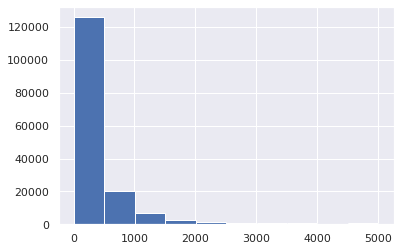

In [10]:
sns.set()
train_df['char_length'].hist()
plt.show()

대부분의 text 길이는 500자 이내이다. 최대 5000자까지

In [11]:
data = train_df[cols_target]

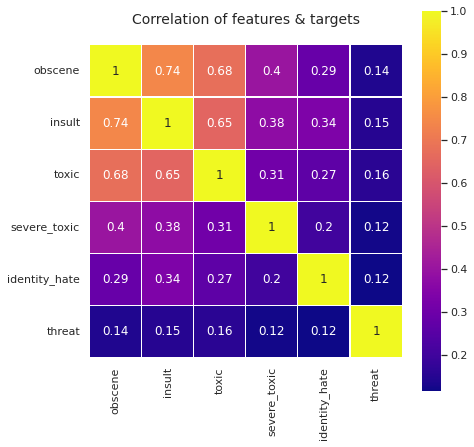

In [12]:
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

상관관계 분석

In [13]:
# 테스트 데이터 확인
test_df['char_length'] = test_df['comment_text'].apply(lambda x: len(str(x)))

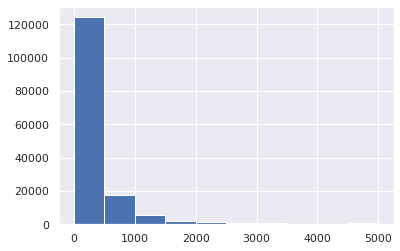

In [14]:
plt.figure()
plt.hist(test_df['char_length'])
plt.show()

In [15]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [16]:
train_df['comment_text'] = train_df['comment_text'].map(lambda com : clean_text(com))

In [17]:
test_df['comment_text'] = test_df['comment_text'].map(lambda com : clean_text(com))

In [18]:
train_df = train_df.drop('char_length',axis=1)
X = train_df.comment_text
test_X = test_df.comment_text

In [19]:
print(X.shape, test_X.shape)

(159571,) (153164,)


In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features=5000,stop_words='english')
vect

TfidfVectorizer(max_features=5000, stop_words='english')

In [22]:
X_dtm = vect.fit_transform(X)
X_dtm

<159571x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 3178792 stored elements in Compressed Sparse Row format>

In [23]:
test_X_dtm = vect.transform(test_X)
test_X_dtm

<153164x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2618972 stored elements in Compressed Sparse Row format>

# 다중 label 분류 문제 해결법

다중 label 분류 문제 해결 방법
- 하나의 class 분류 문제로 쪼개는 법

    1) binary relevance : 각각의 label을 single classification 문제로 분류. 다양한 label간의 상관관계 고려 X

    2) classifier chains : 첫번째 분류기는 input x를 학습한다. 그런뒤 연이은 분류기는 x와 모든 이전의 분류 예측으로 학습된다. 이방법은 예측 변수간의 상관관계로부터 신호를 추출을 시도한다

    3) label powerset : 모든 unique한 label 조합으로 라벨링하여 multi-class problem 로 변환한다. 여기는 6개의 라벨이 있으므로 2**6승인 64개 문제로 바꿈

# binary Relevance : 로지스틱 regression을 사용하여

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg = LogisticRegression(C=12.0)

submission_binary = pd.read_csv('./content/drive/MyDrive/kaggle_code/data/Toxic/sample_submission.csv')

# 하나하나 분류하는 문제로 변경
for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # train the model using X_dtm & y
    logreg.fit(X_dtm, y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    submission_binary[label] = test_y_prob

FileNotFoundError: ignored

# classifier chains : logistic regression을 사용하여 multi-label classifier 문제로 만듬

In [ ]:
def add_feature(X, feature_to_add):
    '''
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    '''
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [ ]:
for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # x와 단일 y의 모델 학습
    logreg.fit(X_dtm,y)
    # 예측
    y_pred_X = logreg.predict(X_dtm)
    print('Training Accuracy is {}'.format(accuracy_score(y,y_pred_X)))
    # test X에서 test y 예측
    test_y = logreg.predict(test_X_dtm)
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    submission_chains[label] = test_y_prob
    # 현재 label의 stack으로 chain함
    X_dtm = add_feature(X_dtm, y)
    print('Shape of X_dtm is now {}'.format(X_dtm.shape))
    # test_X_dtm 현재 label 예측
    test_X_dtm = add_feature(test_X_dtm, test_y)
    print('Shape of test_X_dtm is now {}'.format(test_X_dtm.shape))

In [ ]:
for label in cols_target:
    submission_combined[label] = 0.5*(submission_chains[label]+submission_binary[label])

multi label 분류하는 방법에 대해서 알아가면 좋겠다.